## Table of contents:
* Competition and data overview
* Setting Up ( data and packages )
* Basic exploration/EDA
* Modeling 
    * Stationarity
    * Seasonality , Trend and Remainder
    * AR , MA , ARMA , ARIMA
    * Selecting P and Q using AIC
    * ETS
    * Prophet 
    * UCM
    
    
## Competition and data overview:

In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-[1c company](http://1c.ru/eng/title.htm).

**What does the 1C company do?:**

1C: Enterprise 8 system of programs is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR management, CRM, SRM, MRP, MRP, etc.

**Data**:
We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.


## Visão geral dos Dados e da Competição:

Nesta competição, nosso objetivo é prever o total de vendas um mês a frente, de cada produto para cada loja de uma companhia de Software russa-[1c company](http://1c.ru/eng/title.htm).

**O que a Companhia 1C faz:**

1C: o sistema de programas Enterprise 8 destina-se à automação das atividades empresariais diárias: várias tarefas comerciais de atividades econômicas e de gerenciamento, como contabilidade gerencial, contabilidade comercial, gerenciamento de RH, CRM, SRM, MRP, MRP, etc.

**Dados:**
Nos é fornecido o registro de vendas diário para o par (loja, item), mas nossa tarefa é predizer as vendas a nível mensal.

## Setting Up

In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
import zipfile as zf # handle zip files

# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15,7]


In [151]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh', title=''):
    """ Gráficos ACF, PACF, QQPLOT e de Probabilidades. """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

# remover tendência

def difference(dataset, interval=1) -> pd.Series:
    """ Funcao de diferenciacao: z(t) - z(t-inteval). """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [95]:
# Loading files
unzip_fs = zf.ZipFile('competitive-data-science-predict-future-sales.zip', 'r')

aux = unzip_fs.open('sales_train.csv', 'r')
sales = pd.read_csv(aux)
aux.close()

# aux = unzip_fs.open('items.csv', 'r')
# item = pd.read_csv(aux)
# aux.close()


# Dont need to load
# aux = unzip_fs.open("item_categories.csv")
# item_cat=pd.read_csv(aux)
# aux.close()

# sub=pd.read_csv("sample_submission.csv")

# aux = unzip_fs.open("shops.csv")
# shops=pd.read_csv(aux)
# aux.close()

# aux = unzip_fs.open("test.csv")
# test=pd.read_csv(aux)
# aux.close()

In [96]:
# formatando a coluna 'data' das vendas:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


## Exploratory Data Analysis

O conjunto de dados inclui:
 - 60 lojas diferentes
 - 84 categorias de itens
 - 22.170 itens (quase 264 por categoria)
 - e 2.935.849 registros de vendas/devoluções por dia

Cada registro é identificado por (dia, loja, item) e há um atributo de contagem de quantos itens foram vendidos (se for maior ou igual a "1") ou devolvidos (menor ou igual a "-1") naquele dia. Além disso, esta chave também determina o preço do item naquele dia e naquela loja em especifico. 

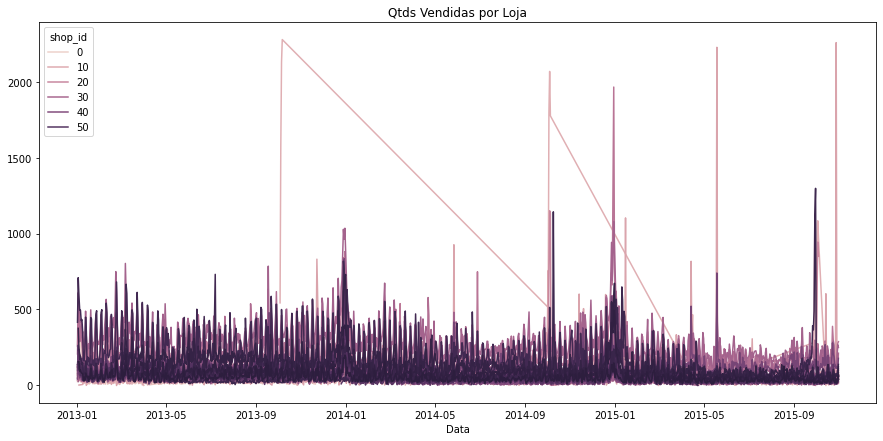

In [118]:
aux = sales.groupby(['date', 'shop_id']).sum('item_cnt_day')

sns.lineplot(x="date", y="item_cnt_day", hue="shop_id", data=aux)
plt.title('Qtds Vendidas por Loja')
plt.xlabel('Data')
plt.ylabel('')
plt.show()

In [143]:
# agrupando todas as vendas da companhia
ts=sales.groupby(by=['date'])["item_cnt_day"].sum()
ts.astype('int')

# separando em conjunto de treino e validação
teste = ts.iloc[974:]
ts = ts.iloc[:-60]
print(f'Obs de treino: {ts.shape[0]} \nObs de teste: {teste.shape[0]}')

Obs de treino: 974 
Obs de teste: 60


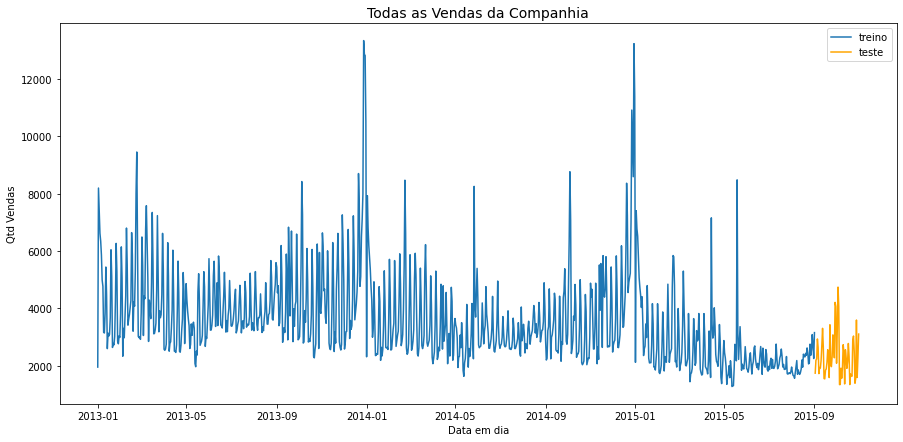

In [149]:
plt.plot(ts, label='treino')
plt.plot(teste, color='orange', label='teste')
plt.title('Todas as Vendas da Companhia', fontsize=14)
plt.xlabel('Data em dia')
plt.ylabel('Qtd Vendas')
plt.legend(fontsize=10)
plt.show()

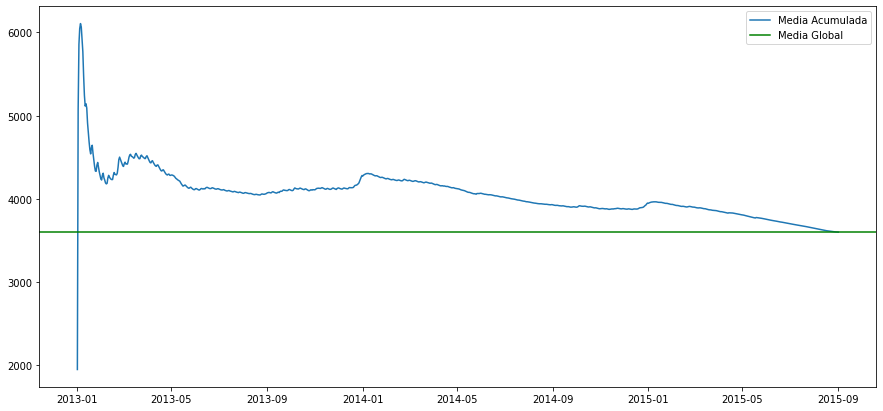

In [348]:
media_acumulada = ts.cumsum()/range(1, len(ts)+1)
plt.plot(media_acumulada, label='Media Acumulada')
plt.axhline(ts.mean(), color='green', label='Media Global')
plt.legend(fontsize=10)
plt.show()

Observa-se pelos gráficos acima que os dados não possuem uma média constante e, dentro do período de um ano, os valores parecem se repetir, isto significa que existe algum fator de tendência e/ou sazonalidade além da componente aleatória.

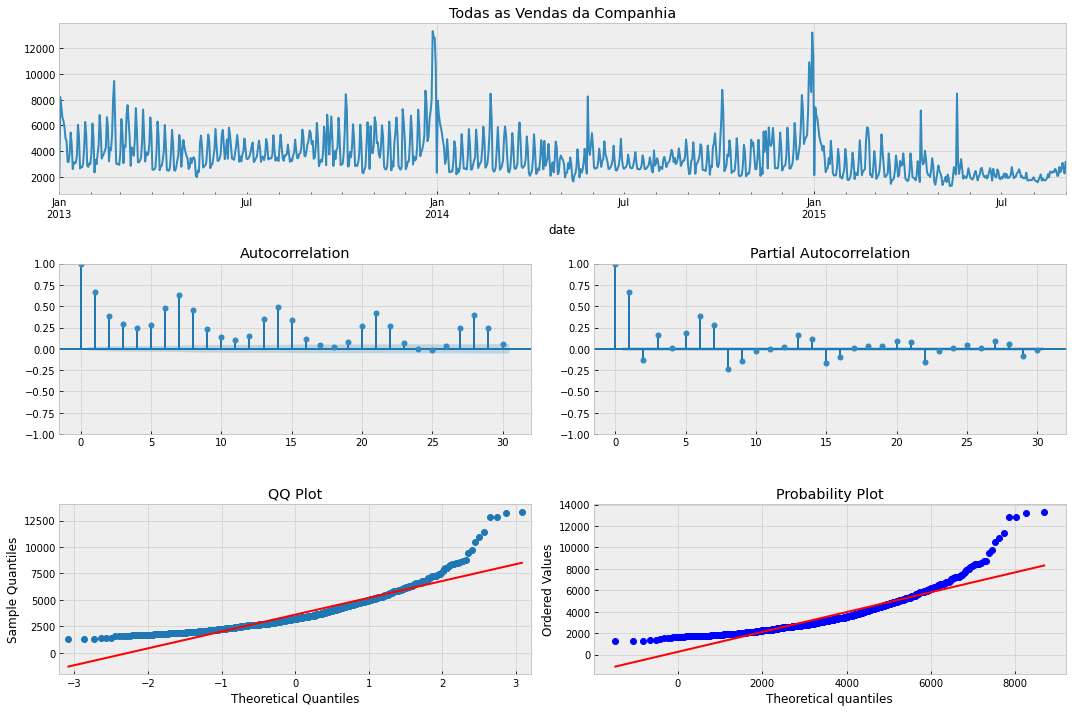

In [153]:
tsplot(ts, title='Todas as Vendas da Companhia')

Dessa vez, verifica-se especificamente a presença de sazonalidade nos dados pelos gráficos de autocorrelação "normal" e parcial. Assim, vamos tentar retirar esta componente determinística das observações.

### Exploring ACF and PACF

Para os gráficos a seguir, considere:
$$X_t = \mu_t \ ? \ S_t \ ? \ Z_t$$

Sendo $X_t$ a quantidade de vendas no dia t, $\mu_t$ uma função de tendência, $S_t$ uma função de sazonalidade, $Z_t$ a componente aleatória e "?" uma relação aditiva ou multiplicativa entre as componentes.

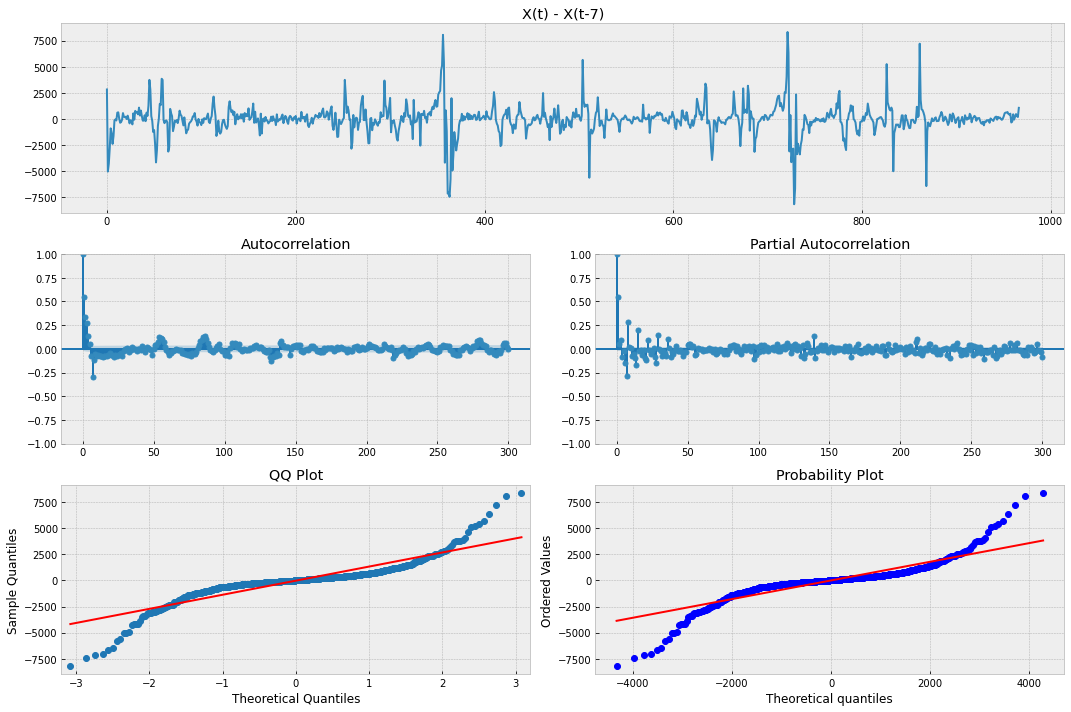

In [356]:
tsplot(difference(ts, 7), lags=300, title='X(t) - X(t-7)')

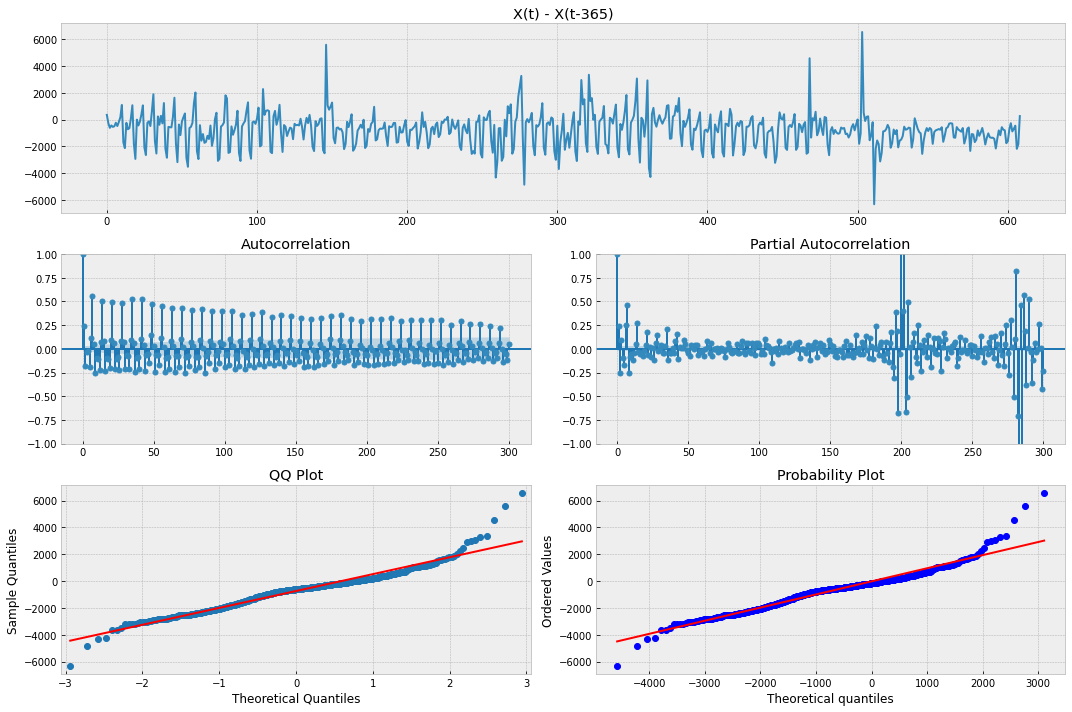

In [357]:
tsplot(difference(ts, 365), lags=300, title='X(t) - X(t-365)')

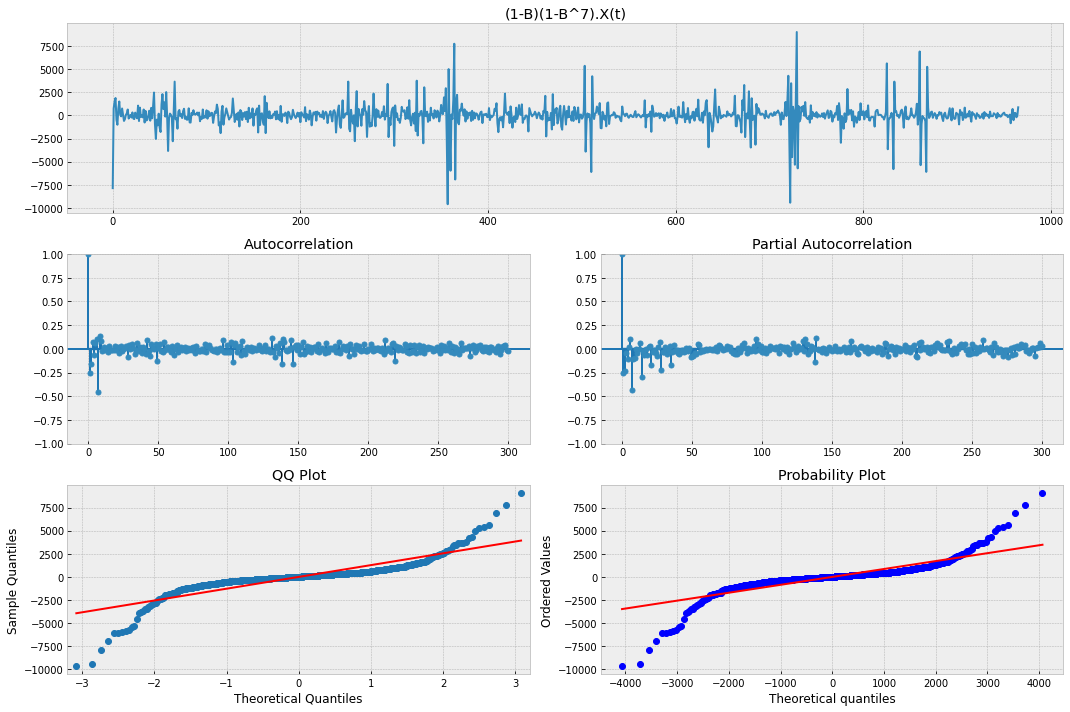

In [358]:
tsplot(difference(difference(ts, 7), 1), lags=300, title='(1-B)(1-B^7).X(t)')

### Exploring Moving Averege

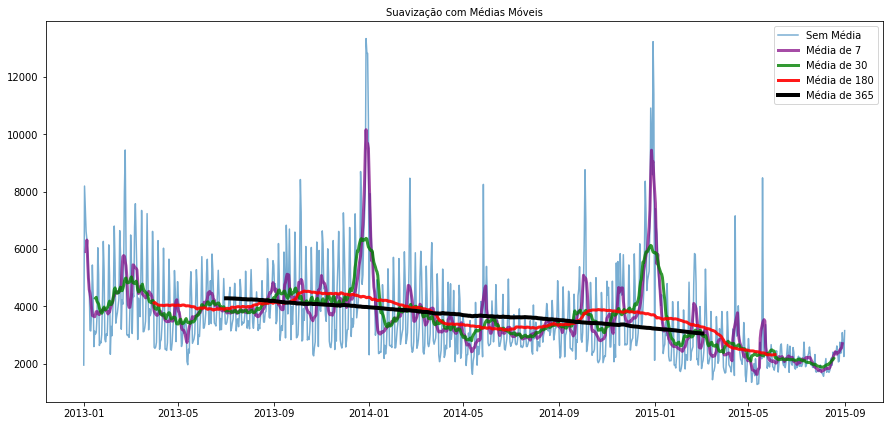

In [336]:
smooth_7 = ts.rolling(7, center=True).mean()
smooth_30 = ts.rolling(30, center=True).mean()
smooth_180 = ts.rolling(180, center=True).mean()
smooth_365 = ts.rolling(365, center=True).mean()

plt.plot(ts, label='Sem Média', alpha=0.6)
plt.plot(smooth_7, color='purple', alpha=0.7, label='Média de 7', linewidth=3)
plt.plot(smooth_30, color='green', alpha=0.8, label='Média de 30', linewidth=3)
plt.plot(smooth_180, color='red', alpha=0.9, label='Média de 180', linewidth=3)
plt.plot(smooth_365, color='black', label='Média de 365', linewidth=4)
plt.title('Suavização com Médias Móveis', fontsize=10)
plt.legend()

plt.show()

In [353]:
smooth_365.dropna(inplace=True)
y = np.array(smooth_365)
tam = smooth_365.shape[0]
x = np.transpose(np.array([[1 for _ in range(tam)],
                           [i for i in range(1, tam+1)]]))

# estimando a função de tendencia
a = np.transpose(x).dot(x)
a = np.linalg.inv(a)
b = np.transpose(x).dot(y)
beta = a.dot(b)
print(f'mu_t = {beta[0]:.2f} + ({beta[1]:.2f})*t')

mu_t = 4310.25 + (-1.94)*t


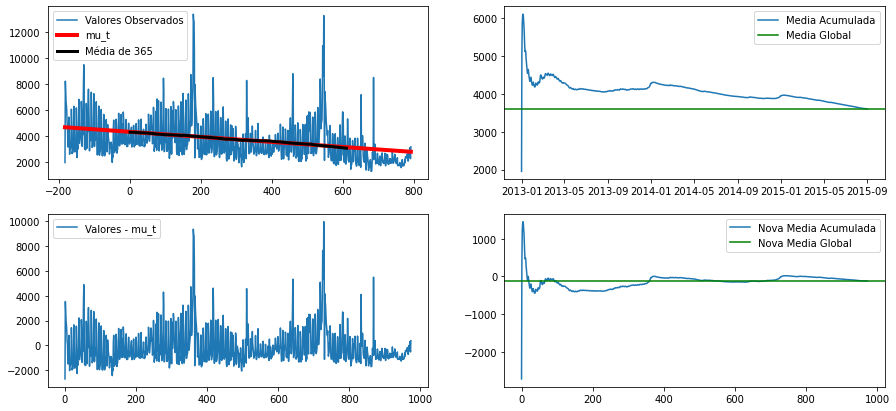

In [352]:
sup = range(-182, len(ts)-182)

plt.subplot(2,2,1)
plt.plot(sup, ts.values, label='Valores Observados')
plt.plot(sup, betas[0] + betas[1]*sup, color='red', label='mu_t', linewidth=4)
plt.plot(x[:, 1], y, label='Média de 365', color='black', linewidth=3)
plt.legend(fontsize=10)

plt.subplot(2,2,2)
plt.plot(media_acumulada, label='Media Acumulada')
plt.axhline(ts.mean(), color='green', label='Media Global')
plt.legend(fontsize=10)

plt.subplot(2,2,3)
ts_detrend = ts.values - betas[0] - betas[1]*sup
plt.plot(ts_detrend, label='Valores - mu_t')
plt.legend(fontsize=10)

plt.subplot(2,2,4)
nova_media_acumulada = ts_detrend.cumsum()/range(1, len(ts)+1)
plt.plot(nova_media_acumulada, label='Nova Media Acumulada')
plt.axhline(ts_detrend.mean(), color='green', label='Nova Media Global')
plt.legend(fontsize=10)

plt.show()

## Modeling

Queremos construir um modelo capaz de predizer o total de vendas por mês de toda a companhia.

Percebe a provável presença de sazonalidade na série, visto que temos picos semelhantemente espaçados em toda sua duração. Além disso, como as vendas parecem diminuir com o tempo, notamos também uma tendência decrescente.

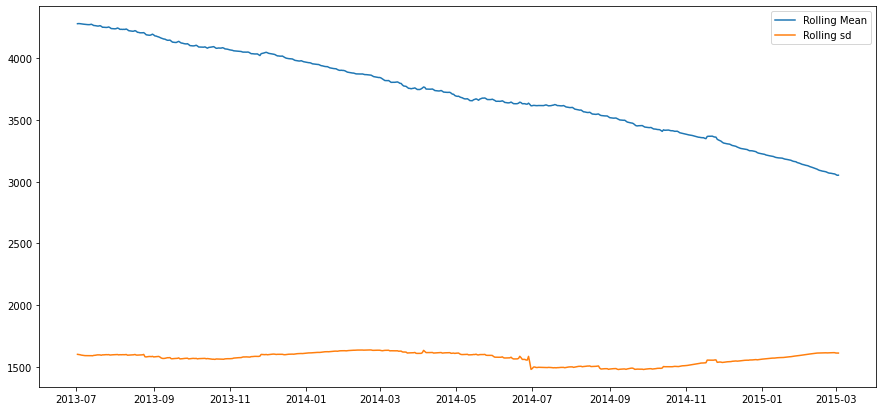

In [355]:
w=365
plt.plot(ts.rolling(window=w,center=True).mean(), label='Rolling Mean')
plt.plot(ts.rolling(window=w,center=True).std(), label='Rolling sd')
plt.legend()
plt.show()

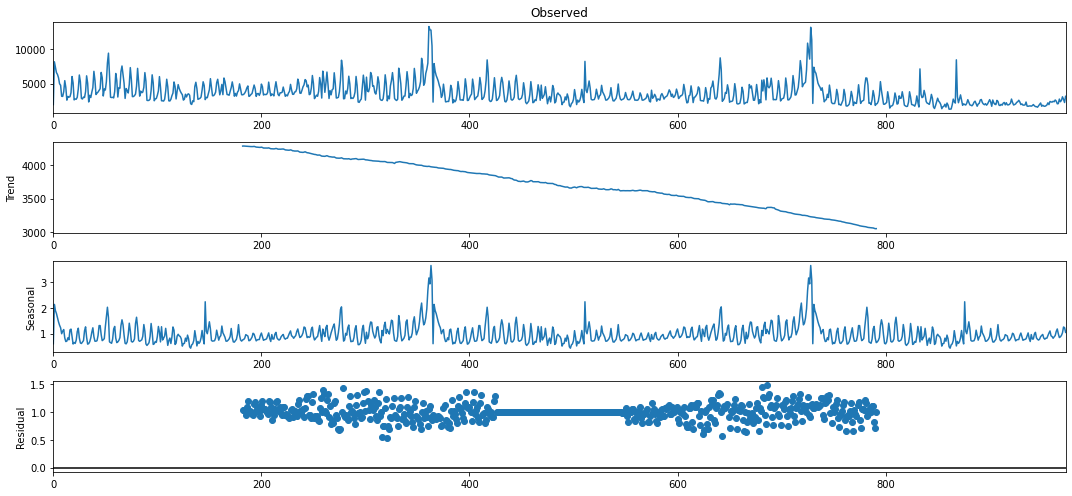

In [315]:
# multiplicative
resm = sm.tsa.seasonal_decompose(ts.values, period=365, model="multiplicative")
fig = resm.plot()
fig.show()

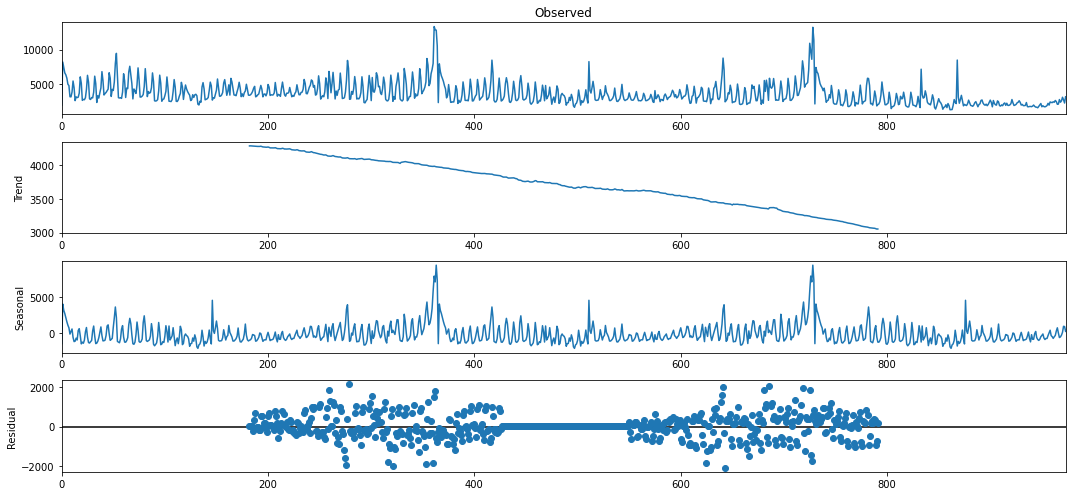

In [308]:
# Additive model
resa = sm.tsa.seasonal_decompose(ts.values, period=365, model="additive")
resa.plot()
plt.show()

# salva resíduos
residuos = pd.DataFrame(resa.resid)
residuos = residuos.dropna()[0].to_numpy()

In [175]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(residuos)


Results of Dickey-Fuller Test:
Test Statistic                -5.679140e+00
p-value                        8.566394e-07
#Lags Used                     1.400000e+01
Number of Observations Used    5.950000e+02
Critical Value (1%)           -3.441388e+00
Critical Value (5%)           -2.866410e+00
Critical Value (10%)          -2.569363e+00
dtype: float64


[]

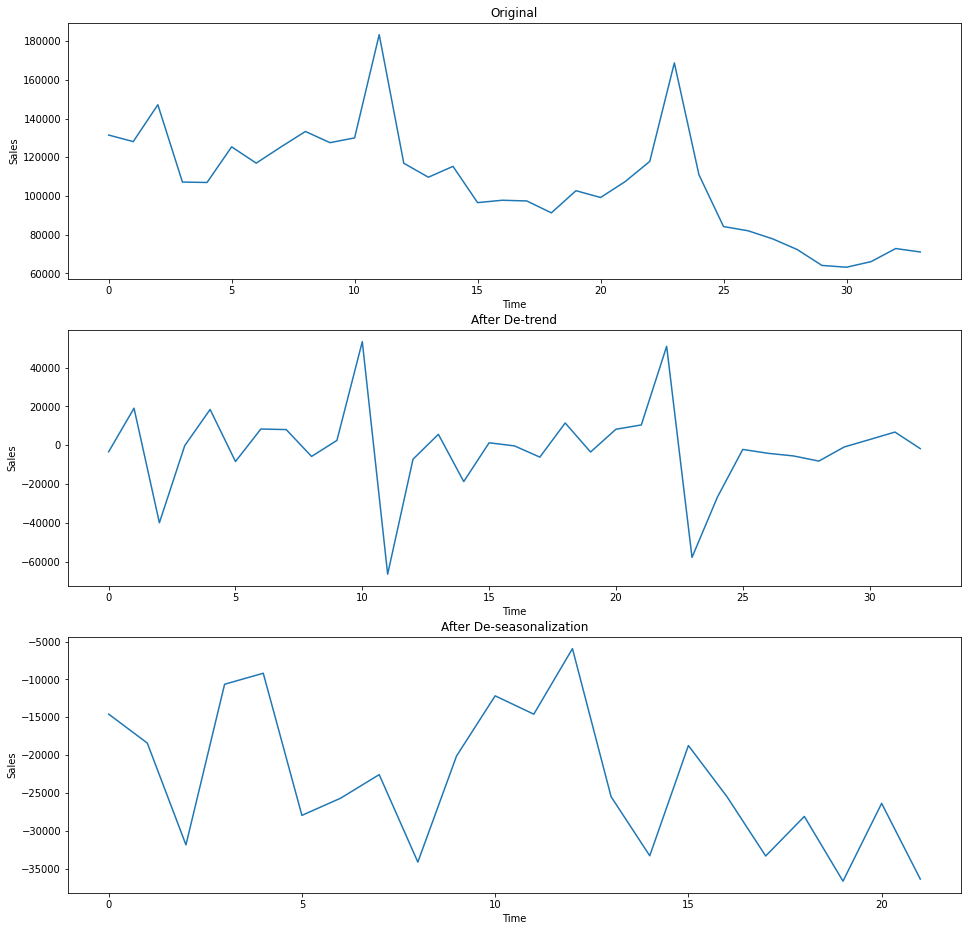

In [31]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

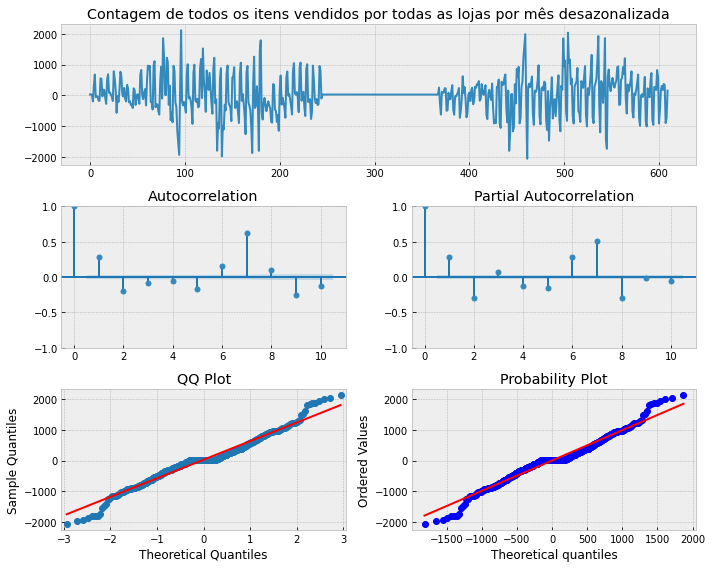

In [176]:
tsplot(residuos, lags=10, title="Contagem de todos os itens vendidos por todas as lojas por mês desazonalizada")

In [177]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(4)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = ARIMA(residuos, order=(i, 0, j)).fit()#ARIMA(arma22, order=(i, 0, j)).fit(method='mle', trend='nc')
            # print(tmp_mdl)
            tmp_aic = tmp_mdl.aic
            print(i,j,tmp_aic)
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


0 0 9545.638115726859
0 1 9457.616529079525
0 2 9446.130445990857
0 3 9440.77262622146
1 0 9498.3412645735
1 1 9450.498302864828
1 2 9444.201842392977
1 3 9437.595759880553
2 0 9445.910888455059
2 1 9443.240345389735
2 2 9444.352814644344
2 3 9317.680178780269
3 0 9444.873750531848
3 1 9445.237222872558
3 2 9446.153518182247
3 3 9378.681252922
aic: 9317.68018 | order: (2, 3)


In [178]:
model = ARIMA(residuos, order=(2, 0, 3)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  610
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -4651.840
Date:                Sat, 03 Dec 2022   AIC                           9317.680
Time:                        18:42:07   BIC                           9348.574
Sample:                             0   HQIC                          9329.698
                                - 610                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.2930     28.773      0.949      0.343     -29.101      83.687
ar.L1         -0.4476      0.006    -71.546      0.000      -0.460      -0.435
ar.L2         -0.9960      0.006   -163.239      0.0

In [146]:
## antigo
model = ARIMA(residuos, order=(2, 0, 3)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  670
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -5144.135
Date:                Sat, 03 Dec 2022   AIC                          10302.269
Time:                        18:23:24   BIC                          10333.820
Sample:                             0   HQIC                         10314.490
                                - 670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.9050     29.414      0.915      0.360     -30.745      84.555
ar.L1         -0.4501      0.002   -228.079      0.000      -0.454      -0.446
ar.L2         -0.9991      0.002   -550.287      0.0

### SARIMA